The code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. 

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

# Imports & Setting up directories

In [61]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/
    %pip install torchdiffeq
else:
    import sys; sys.path.insert(0, '..') 
    import os
    PATH = '../'


In [62]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

# Code

## Data Generation

Similar to https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

### Dynamics

In [63]:
def pendulum_H(q, p, m, g, l):
    H = (1/(2*m*(l**2)))*p**2 + m*g*l*(1-torch.cos(q))  
    return H

def hamiltonian_fn_pend(coords, m, g, l):
    q, p = torch.split(coords,1)
    H = pendulum_H(q,p, m, g, l)
    return H

def coord_derivative_pend(t, coords, C, m, g, l, u_func, g_func):

    if coords.requires_grad is not True:
      coords.requires_grad=True
    H = hamiltonian_fn_pend(coords, m, g, l)

    # derivaties of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True)
    
    dHdq, dHdp = torch.split(dcoords[0],1)

    u = u_func.forward(t)
    G = g_func.forward(coords)

    dqdt = dHdp + G[0]*u
    dpdt = -dHdq - C*dHdp + G[1]*u

    return dqdt, dpdt

def dynamics_fn_pend(t, coords, C, m, g, l, u_func, g_func):

    dqdt, dpdt = coord_derivative_pend(t, coords, C, m, g, l, u_func, g_func)
    # symplectic gradient
    S = torch.hstack((dqdt, dpdt)) 
    return S 

### Trajectory and energy

In [64]:
def chirp_fun(t,T=1.5,f0=1,f1=50, scale =1):
    # https://en.wikipedia.org/wiki/Chirp
    c = (f1-f0)/T
    return torch.sin(2*torch.pi*(c*t**2/2 + f0*t))*scale

def multi_sine(t, scale = 0.5):
    f = torch.tensor([2,10,3,4], device = t.device).unsqueeze(dim=1)
    A = torch.tensor([2,0.5,0.3,0.8], device = t.device).unsqueeze(dim=1)
    return (A*torch.sin(2*torch.pi*t*f)).sum(dim=0)*scale

def step_fun(t, t1=0.05, scale=0.1):
    f = torch.zeros_like(t)
    f[t < t1] = 0
    f[~(t < t1)] = scale
    return f

class U_FUNC():
    def __init__(self, utype=None, params={}):
        super(U_FUNC).__init__()
        self.utype = utype
        self.params = params # dict containing params for the input function
        self.params['T'] = 1.5
        self.params['f0'] = 1
        self.params['f1'] = 10
        self.params['scale'] = 1

    def forward(self, t):  
        ''' time dependent input '''
        if self.utype == 'tanh':
            u = (-torch.tanh((t-0.75)*4)+1)/100
        elif self.utype == 'chirp':
            u = chirp_fun(t,
                            T=self.params['T'],
                            f0=self.params['f0'],
                            f1=self.params['f1'],
                            scale = self.params['scale'])
        elif self.utype == 'multisine':
            u = multi_sine(t, scale = self.params['scale'])
        elif self.utype == 'step':
            u = step_fun(t, t1=0.5)
        elif self.utype is None:
            u = torch.zeros(t.shape, device=t.device)
        u.requires_grad=False
        return u

class G_FUNC():
    def __init__(self, gtype=None, params={}):
        super(G_FUNC).__init__()
        self.gtype = gtype
        self.params = params # dict containing params on
        self.params['q_ref']= torch.tensor([1.0],device=device)
    
    def forward(self, coords): 
        ''' state dependent input '''
        q,p = torch.split(coords,1,dim=-1)
        if self.gtype=='simple':
            if len(q.shape)==1:
                dimension = 0
            else:
                dimension = 1
            g = torch.stack((torch.zeros(q.shape[0]),torch.ones(q.shape[0])), dim=dimension)
        # elif self.gtype=='setpoint':
        #     if len(q.shape)==1:
        #         dimension = 0
        #     else:
        #         dimension = 1
        #     g = torch.stack((torch.zeros(q.shape[0]),torch.ones(q.shape[0])*q-self.params['q_ref']), dim=dimension)
        elif self.gtype is None:
            g = torch.zeros(q.shape[0], 2, device = q.device)
        g.requires_grad = False
        return g

def get_trajectory_pend(device, time_steps, Ts, y0, noise_std, C, m, g, l, u_func, g_func):
    '''
    Similar to SymODEN repository
    '''

    t_eval = torch.linspace(1, time_steps, time_steps, device=device) * Ts # evaluated times vector
    
    # get initial state
    if y0 is None:
        y0 = torch.rand(2)*4.-2 # uniform law [-2,2]
        y0[1]=0

    q_p = odeint(func = lambda t, coords : dynamics_fn_pend(t, coords, C, m, g, l, u_func, g_func) , y0 = y0, t = t_eval, method = 'rk4', options=dict(step_size=Ts)) 

    q, p = torch.chunk(q_p,2,1)

    # add noise 
    q = q+torch.randn(q.shape, device=device)*noise_std 
    p = p+torch.randn(p.shape, device=device)*noise_std 

    return q.detach().squeeze(), p.detach().squeeze(), t_eval.detach() 

In [65]:
def energy_pendulum(theta_dot, theta, m, g, l):
    '''
    This function calculates the energy of the simple pendulum in function of 
    the angle theta and it's derivative
    Inputs :
        - theta_dot : 
        - theta : 
        - m : pendulum mass 
        - g : 
        - l : length of arm
    Outputs:
        - E () : Energy of the system
    '''
    E = (1/2)*m*(l**2)*theta_dot**2 + m*g*l*(1-torch.cos(theta))
    return E
    
def get_energy_pendulum(t_eval, u_func, g_func,  q,p, C, m, g, l):

    energy = []
    derivatives = []

    coords = torch.stack((q, p),dim=1)
    for i in range(len(t_eval)):

      dqdt, dpdt = coord_derivative_pend(t_eval[i], coords[i,:], C, m, g, l, u_func, g_func)

      theta_dot = dqdt
      theta = coords[i,0]

      energy.append(energy_pendulum(theta_dot, theta, m, g, l))
      derivatives.append(torch.hstack((dqdt, dpdt)))

    energy = torch.hstack(energy).detach() # torch.cat(energy, axis=0 ).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy.squeeze(), derivatives.squeeze()

#### Multiple trajectories

In [66]:
def multiple_trajectories(time_steps, num_trajectories, device, Ts, y0, 
                                noise_std, C, m, g, l, u_func, g_func, coord_type = 'hamiltonian'):
    '''
    
    '''
    # the first trajectory
    q, p, t_eval = get_trajectory_pend(device, time_steps, Ts, y0, 
                                noise_std, C, m, g, l, u_func, g_func)
    energy, derivatives = get_energy_pendulum(t_eval, u_func, g_func, q, p, C, m, g, l)
    energy = energy.squeeze()
    q = q.squeeze()
    if coord_type == 'hamiltonian':
        p = p.squeeze()
    if coord_type == 'newtonian':
        p = derivatives[:,0].squeeze()
    
    derivatives = derivatives.unsqueeze(dim=0)

    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q_n, p_n, _ = get_trajectory_pend(device, time_steps, Ts, y0, 
                                noise_std, C, m, g, l, u_func, g_func)
        energy_n, derivatives_n = get_energy_pendulum(t_eval, u_func, g_func, q_n, p_n, C, m, g, l)

        energy = torch.vstack((energy, energy_n.squeeze()))
        q = torch.vstack((q, q_n.squeeze()))

        if coord_type == 'hamiltonian':
            p = torch.vstack((p, p_n.squeeze()))
            p = p.squeeze()
        if coord_type == 'newtonian':
            p = torch.vstack((p, derivatives_n[:,0].squeeze()))
        
        derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))

    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q = q.unsqueeze(dim=0) 
        p = p.unsqueeze(dim=0) 
        energy = energy.unsqueeze(dim=0) 
    return q.t(), p.t(), t_eval, energy.t(), torch.permute(derivatives, (1,0,2)) #

### Dataset & Dataloader

In [67]:
class TrajectoryDataset(Dataset):
    '''
    
    '''
    def __init__(self, q, p, t_eval):
        self.q = q
        self.p = p
        self.t_eval = t_eval

    def __len__(self):
        return self.q.shape[1]

    def __getitem__(self, idx):
        q = self.q[:,idx]
        p = self.p[:,idx]
        t_eval = self.t_eval#[idx].squeeze()
        x = torch.stack((q,p),dim=1)#.t().float()
        return x, t_eval

In [68]:
def data_loader(q, p, t_eval, batch_size, shuffle = True, proportion = 0.5):
    '''
    '''
    # split  into train and test 
    if proportion:

        full_dataset = TrajectoryDataset(q, p, t_eval)

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train, test = random_split(full_dataset, [train_size, test_size])

        # q_train, q_test = train_test_split_torch(q, test_size=proportion, random_state=0)
        # p_train, p_test = train_test_split_torch(p, test_size=proportion, random_state=0)

        # test = TrajectoryDataset(q_test, p_test, t_eval)

        test_loader = DataLoader(
            test,
            batch_size,
            shuffle
            )    
    else:
      train = TrajectoryDataset(q, p, t_eval)
      # if proportion is set to None don't split the dataset
      q_train = q
      p_train = p
      t_eval_train = t_eval
      test_loader = None

    # load the training data into a custom pyotorch dataset
    # train = TrajectoryDataset(q_train, p_train, t_eval)

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

## Plots

In [69]:
def plot_traj_pend(t_eval, q, p, energy=torch.tensor(False), input=torch.tensor(False), coord_type = 'hamiltonian'):
    '''
    This function plots the generalised variable q p in function of the evaluation 
    time
    Inputs:
      t_eval ()
      q ()
      p ()
    Outputs:
      None
    '''
    if torch.any(energy):
      if torch.any(input):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12, 4),constrained_layout=True)#, sharex=True)# , sharey=True)
        ax3.plot(t_eval, energy, label='energy')
        
        #ax1.legend()
        ax3.set_title('Energy', fontsize=10)
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('E')
        ax3.set_ylim((0,torch.max(energy)*1.1))

        ax4.plot(t_eval, input, label='energy')
        ax4.set_title('Input', fontsize=10)
        ax4.set_xlabel('time (s)')
        ax4.set_ylabel('U')
        # ax4.set_ylim((0,torch.max(input)*1.1))
      else :
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4),constrained_layout=True)#, sharex=True)# , sharey=True)
        ax3.plot(t_eval, energy, label='energy')

        #ax1.legend()
        ax3.set_title('Energy', fontsize=10)
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('E')
        ax3.set_ylim((0,torch.max(energy)*1.1))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q, label='q')
    ax2.plot(t_eval, p, label='p')

    #ax1.legend()
    ax1.set_title('generalized position (q)', fontsize=10)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('q')

    #ax2.legend()
    ax2.set_title('generalized momentum (p)', fontsize=10)
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('p')

    fig.suptitle('Trajectory of the generalized coordinates', fontsize=12)
    

    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q}[rad/s]$')

    plt.show()
    return

## Models

### Base models

#### MLP

In [70]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x


class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)


#### Resnets

In [71]:
class ResNet_config1(torch.nn.Module):
    '''
    Model compose of [ MLP - RESBLOCK1 - RESBLOCK2] used in the following way:
    First we train the model with only the MLP, then we introduce RESBLOCK1 when we increase the horizon, 
    but initialise RESBLOCK1 with very small weights, 
    '''
    def __init__(self, resblock_list, num_blocks =4, input_dim=4, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config1, self).__init__()
        
        self.resblocks = [MLP(input_dim=output_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=output_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=output_dim, activation=activation_mlp)
        
        self.resblock_list = resblock_list
        self.make_params_small() # make the resblock parameters small
        
    def forward(self, x):

        y = self.mlp(x)

        for i in self.resblock_list:
            y = self.resblocks[i](y) + y

        return y
    
    def make_params_small(self):
        with torch.no_grad():
            for i in range(len(self.resblocks)):
                for param in self.resblocks[i].parameters():
                    param.copy_(param/1000)


In [72]:
class ResNet_config2(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, resblock_list, num_blocks =4, input_dim=4, hidden_dim=25, nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config2, self).__init__()

        self.resblocks = [MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=input_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=output_dim, activation=activation_mlp)
        
        self.resblock_list = resblock_list

    def forward(self, x):
        y = x

        for i in self.resblock_list:
            y = self.resblocks[i](y) + y

        y = self.mlp(y)
        return y

    def init_new_resblocks(self,i,j):
        # i and j are the new resblocks to be initialised
        # in our simple case we introduce reblocks 1 and 2 between resblocks 0 and 3

        with torch.no_grad():
            for param1, param2, param3, param4 in zip(self.resblocks[i-1].parameters(),self.resblocks[i].parameters(), self.resblocks[j].parameters(), self.resblocks[j+1].parameters()):

                param2.copy_((param1 + param2)/2)
                param3.copy_((param3 + param4)/2)


In [73]:
class ResNet_config3(torch.nn.Module):
    '''
    Model compose of [RESBLOCK1 - RESBLOCK2 - MLP] used in the following way:
    First we train the model with only the MLP, then we introduce RESBLOCK1 when we increase the horizon, 
    but initialise RESBLOCK2 with very small weights, 
    '''
    def __init__(self, resblock_list, num_blocks =4, input_dim=4, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config3, self).__init__()
        
        self.resblocks = [MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=input_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                                 output_dim=output_dim, activation=activation_mlp)
        
        self.resblock_list = resblock_list
        self.make_params_small() # make the resblock parameters small
        
    def forward(self, x):

        y = x

        for i in self.resblock_list:
            y = self.resblocks[i](y) + y
        y = self.mlp(y)
        return y
    
    def make_params_small(self):
        with torch.no_grad():
            for i in range(len(self.resblocks)):
                for param in self.resblocks[i].parameters():
                    param.copy_(param/1000)


### U-ODE-HNN

In [74]:
class U_ODE_HNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module
    Equivalent of unconstrained ODE HNN from the report
    Architecture for input (q, p, u), 
    where q and p are tensors of size (bs, n) and u is a tensor of size (bs, 1)
    '''
    def __init__(self, input_dim, H_net=None, M_net=None, V_net=None, g_net=None, device=None,
                    assume_canonical_coords=True, baseline=True, structure=False):
        super(U_ODE_HNN, self).__init__()
        self.baseline = baseline
        self.structure = structure

        self.H_net = H_net
        self.g_net = g_net

        self.device = device
        self.assume_canonical_coords = assume_canonical_coords

        self.input_dim = input_dim
        
        # add a learnable dissipation coefficient
        self.C_dissip = torch.nn.Parameter(torch.tensor([0.5]))  # torch.nn.Parameter(torch.rand(1))
        self.C_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            q, p = torch.chunk(x,2,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq , dHdp = torch.chunk(dH,2,dim=-1)

            dqdt = dHdp 

            dpdt = -dHdq - self.C_dissip*dHdp

            # symplectic gradient 
            S_h = torch.cat((dqdt, dpdt), 
                            dim=-1) 
            return S_h 

### Nes_HDNN

In [75]:
class Nes_HDNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, u_func = None, G_net=None, H_net=None, device=None, dissip=False):
        super(Nes_HDNN, self).__init__()
        self.H_net = H_net
        self.G_net = G_net
        self.u_func = u_func

        self.device = device
        self.dissip = dissip
        # add learnable dissipation coefficients
        self.C = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C.requires_grad = True


    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq, dHdp= torch.chunk(dH,2,dim=-1)
            

            G = self.G_net.forward(q_p)

            if self.u_func:
                u = self.u_func.forward(t)
            else:
                u = torch.tensor([0.0])
            dqdt = dHdp 
            if self.dissip:

                dpdt = -dHdq + (G[:,1].T*u).unsqueeze(dim=1)  - self.C.pow(2)*dHdp
            else:
                dpdt = -dHdq + (G[:,1].T*u).unsqueeze(dim=1)
            # symplectic gradient 
            S_h = torch.cat((dqdt, dpdt), 
                            dim=-1) 
            
            return S_h

    def freeze_G_net(self, freeze=True): 
        """
        Only freez the G_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
        
        outputs:
            None

        """
        for param in self.G_net.parameters(): 
            param.requires_grad = (not freeze)

    def freeze_H_net(self, freeze=True): 
        """
        Only freez the H_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
      
        outputs:
            None
        """
        for param in self.H_net.parameters(): 
            param.requires_grad = (not freeze)

### Autoencoder

In [76]:
class Autoencoder(torch.nn.Module):
    '''Just a MLP
    From the SymODEN repository
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=2, dec_in_dim = 2, dec_out_dim = 2, activation='tanh'):
        super(Autoencoder, self).__init__()

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)
        # q,p=torch.split(x,1,dim=2)
        p_hat = self.encoder(x) # coordinates in the latent space

        # z_h = torch.cat((q,z),dim=2) # input known q and encoded z into decoder
        q_dot_hat = self.decoder(p_hat) # coordinates back in the original space but using the decoder

        return p_hat, q_dot_hat

In [77]:
def train_autoencoder():

    lr = 1e-3
    Ts = 0.05

    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    w=torch.tensor([0.1,1.0], device=device)

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0

        t1 = time.time()

        #horizon = select_horizon(step)

        # Training
        for x, t_eval in iter(train_loader):
            x = torch.permute(x, (1,0,2)) # to have the same dimensions as odeint
            t_eval = t_eval[0,:horizon] #t_eval.squeeze()
           
            train_z, train_x_hat = autoencoder(x)
            train_loss_mini = L2_loss(x[:, :, :], train_x_hat[:],w) # batch loss
            
            train_loss = train_loss + train_loss_mini # epoch loss

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        # Testing
        if test_loader:
            if not (step%10):
                for x, t_eval in iter(test_loader):
                    x = torch.permute(x, (1,0,2)) 

                    t_eval = t_eval[0,:horizon] # t_eval.squeeze()

                    
                    test_x_hat = odeint(model, x[0, :, :], t_eval, method='rk4', options=dict(step_size=Ts))
                    
                    test_loss_mini = L2_loss(x[:horizon, :, :], test_x_hat[:horizon],w) 
                    test_loss = test_loss + test_loss_mini
                
                print('epoch', step, '| train loss ', train_loss.item(), '| test loss', test_loss.item(), '| train time:',train_time)
                stats['test_loss'].append(test_loss.item())
        else:
            if not (step%10):
                print('epoch', step, '| train loss ', train_loss.item(),'| train time:',train_time)

        # logging
        stats['train_loss'].append(train_loss.item())
        
    return stats

## Utils

In [78]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def set_device():
    # set device to GPU if available otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Available device : {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

## Train

### loss

In [79]:
def L2_loss(u, v, w = False, dim = (0,1), param = 'L2'):
    # u nominal
    # v approximate
    # u and v expected with shape : [time_steps, batch_size , (q1,p1)] 
    if param == 'L2':
        # mean only over time steps and batch_size 
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2weighted':
        loss = (((u-v).mul(w)).pow(2)).mean(dim = dim ).sum()
    return loss # ((u-v)*w).pow(2).mean()

In [80]:
def load_model(model_name='U_ODE_HNN'):
    H_net = MLP(input_dim=2, hidden_dim=130, output_dim=1, nonlinearity='tanh', bias_bool=True)

    if model_name == 'U_ODE_HNN':
        model = U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=device,
                            assume_canonical_coords=True, baseline=True, structure=False)
    if model_name == 'Newtonian_U_ODE_HNN':
        model = Newtonian_U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=device,
                            assume_canonical_coords=True, baseline=True, structure=False)

    model.to(device)
    return model

In [81]:
def load_model_nes_hdnn(device, g_func=None, u_func=None, hidden_dim=90, nb_hidden_layers=4):
    H_net = MLP(input_dim=2, hidden_dim=60, nb_hidden_layers=2, output_dim=1, activation='x+sin(x)^2')
    if g_func is None :
        G_net = MLP(input_dim=2, hidden_dim=40, nb_hidden_layers=1, output_dim=2, activation='tanh')
        model = Nes_HDNN(u_func=u_func, G_net=G_net, H_net=H_net, device=device)
    else :      
        model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device)
    model.to(device) 

    return model 

### horizon

In [82]:
def select_horizon_list(step, horizon_list = [50,100,150,200,250,300], switch_steps = [200,200,200,150,150,150]):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # throw error if horizon_list and switch_steps not of the same length
    assert len(horizon_list)==len(switch_steps), ' horizon_list and switch_steps must have same length'

    if step <switch_steps[0]:
        horizon = horizon_list[0]
        if step==0:
            print('horizon length :', horizon)
    elif step < sum(switch_steps):
        for i in range(1,len(switch_steps)):
            if (step >= sum(switch_steps[0:i]))&(step < sum(switch_steps[0:i+1])):
                horizon = horizon_list[i]
                if step==sum(switch_steps[0:i]):
                    print('horizon length :', horizon)
    else:
        horizon = horizon_list[-1]
    return horizon 

### resnet depth

In [83]:
def multilevel_strategy_update(step, model, resnet_config):
    '''
    
    '''
    # resnet strategy 1 :
    if resnet_config == 1 or resnet_config == 3:
        if step <= sum(switch_steps[:1]):
            # print('Model size increased')
            model.H_net.resblock_list = [0]
        elif step == sum(switch_steps[:1]) and len(model.H_net.resblocks)>=2:
            print('Model size increased')
            model.H_net.resblock_list = [0,1]
        elif step == sum(switch_steps[:2]) and len(model.H_net.resblocks)>=3:
            print('Model size increased')
            model.H_net.resblock_list = [0,1,2]
        elif step == sum(switch_steps[:3]) and len(model.H_net.resblocks)>=4:
            print('Model size increased')
            model.H_net.resblock_list = [0,1,2,3]
        elif step == sum(switch_steps[:4]) and len(model.H_net.resblocks)>=5:
            print('Model size increased')
            model.H_net.resblock_list = [0,1,2,3,4]
        elif step == sum(switch_steps[:5]) and len(model.H_net.resblocks)>=6:
            print('Model size increased')
            model.H_net.resblock_list = [0,1,2,3,4,5]

    # resnet strategy 2 :
    if resnet_config == 2:
        if step <= sum(switch_steps[:1]): # init : [0,1,2,3,4,5,6,7,8,9,10,11]
            # print('Model size increased')
            model.H_net.resblock_list = [0,11]
        elif step == sum(switch_steps[:1]) and len(model.H_net.resblocks)>=4:
            print('Model size increased')
            model.H_net.init_new_resblocks(1,10)
            model.H_net.resblock_list = [0,1,10,11]
        elif step == sum(switch_steps[:2]) and len(model.H_net.resblocks)>=6:
            print('Model size increased')
            model.H_net.init_new_resblocks(2,9)
            model.H_net.resblock_list = [0,1,2,9,10,11]
        elif step == sum(switch_steps[:3]) and len(model.H_net.resblocks)>=8:
            print('Model size increased')
            model.H_net.init_new_resblocks(3,8)
            model.H_net.resblock_list = [0,1,2,3,8,9,10,11]
        elif step == sum(switch_steps[:4]) and len(model.H_net.resblocks)>=10:
            print('Model size increased')
            model.H_net.init_new_resblocks(4,7)
            model.H_net.resblock_list = [0,1,2,3,4,7,8,9,10,11]
        elif step == sum(switch_steps[:5]) and len(model.H_net.resblocks)>=12:
            print('Model size increased')
            model.H_net.init_new_resblocks(5,6)
            model.H_net.resblock_list = [0,1,2,3,4,5,6,7,8,9,10,11]
    return model

### train function

In [84]:
def train(model, Ts, train_loader, test_loader, w, resnet_config = False, horizon=False, horizon_type=False,
          horizon_list = [50,100,150,200,250,300], 
          switch_steps = [200,200,200,150,150,150],
          epochs = 20, 
          loss_type = 'L2weighted'):
    '''
    Description:

    Inputs:

    Outpus:  
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    
    lr = 1e-3

    optim = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4) # Adam

    logs = {'train_loss': [], 'test_loss': []}
    # weight for loss function

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            pass
        #     horizon, num_steps= select_horizon_wschedule(step,optim,
        #                                                   epoch_number,
        #                                                   switch_steps)
        #     if num_steps :
        #         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)
        elif horizon_type == 'auto': 
            horizon = select_horizon_list(step, horizon_list, switch_steps)
        # increase the model size and initialie the new parameters
        if resnet_config:
            model = multilevel_strategy_update(step, model, resnet_config)
        model.train()
        for x, t_eval in iter(train_loader): # we don't really need u since the model knows u_func
            # x is [batch_size,(q1,p1,q2,p1),time_steps]

            t_eval = t_eval[0,:horizon]
            
            train_x_hat = odeint(model, x[:, 0, :], t_eval, method='rk4', options=dict(step_size=Ts))            
            # train_x_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 
            #train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])

            train_loss_mini = L2_loss(torch.permute(x[:, :horizon, :], (1,0,2)) , train_x_hat[:horizon,:,:], w, param = loss_type)
            # after permute x is [time_steps, batch_size, (q1,p1,q2,p1),]

            # loss(u, v, w = False, dim = (0,1), param = loss_type)
            # if not step%10:
            #     t_plot = time.time()
            #     training_plot(t_eval, train_x_hat[:horizon,:,:], x[:, :, :horizon])
            #     print('plot time :' , time.time()-t_plot)

            train_loss = train_loss + train_loss_mini.item()

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad()
            # if (horizon == 'schedule') and do_step:
            #   scheduler.step()


        t2 = time.time()
        train_time = t2-t1

        model.eval()
        if test_loader: 
            with torch.no_grad(): # we won't need gradients for testing
                if not (step%10): # run validation every 10 steps
                    for x, t_eval in iter(test_loader):
                        # run test data
                        t_eval = t_eval[0,:horizon]
      
                        test_x_hat = odeint(model, x[:, 0, :], t_eval, method='rk4', options=dict(step_size=Ts))      
                        #test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                        test_loss_mini = L2_loss(torch.permute(x[:, :horizon, :], (1,0,2)) , test_x_hat[:horizon,:,:], w, param = loss_type)
              

                        test_loss = test_loss + test_loss_mini.item()
                    test_time = time.time()-t2
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                          .format(step, train_time, train_loss, test_loss,test_time))
                    logs['test_loss'].append(test_loss)
                    
                else:
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                          .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        logs['train_loss'].append(train_loss)
    return logs

In [85]:
def load_data_device(time_steps, num_trajectories, device, batch_size, proportion, shuffle, Ts, y0, 
                                noise_std, C, m, g, l, u_func, g_func, coord_type = 'hamiltonian'):
    # create trajectories
    q, p, t_eval,_,_ = multiple_trajectories(time_steps=time_steps, num_trajectories=num_trajectories, device=device, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = coord_type)

    q=q.to(device) 
    p=p.to(device) 
    t_eval=t_eval.to(device) 

    # dataloader to load data in batches
    train_loader, test_loader = data_loader(q, p, t_eval, batch_size, shuffle = shuffle, proportion = proportion)
    return train_loader, test_loader

# Sanity checks

In [28]:
device = set_device()
time_steps = 40
y0 = None
noise_std = 0.0
Ts = 0.05
C = 0.0
m = 1
g = 9.81
l = 1
utype = 'sine'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 2.0
u_func.params['f0'] = 0
u_func.params['f1'] = 1
u_func.params['scale'] = 1
gtype='simple'
g_func = G_FUNC(gtype=gtype)

cpu


In [ ]:
q, p, t_eval = get_trajectory_pend(device, time_steps, Ts, y0, 
noise_std, C, m, g, l, u_func, g_func)

energy, derivatives = get_energy_pendulum(t_eval, u_func, g_func, q,p, C, m, g, l)

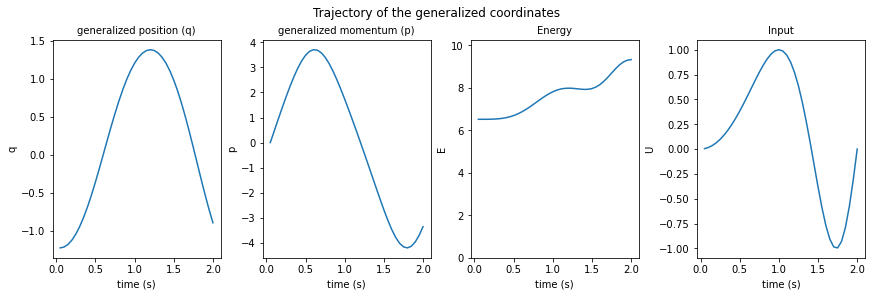

In [ ]:
input = u_func.forward(t=t_eval)
plot_traj_pend(t_eval, q, p, energy, input) # sanity check 

In [ ]:
q, p, t_eval,_,_=q, p, t_eval, energy, derivatives = multiple_trajectories(time_steps=time_steps, num_trajectories=10, device=device, Ts=Ts, y0=y0, noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')

In [ ]:
train_loader, test_loader = data_loader(q, p, t_eval, batch_size=3, shuffle = True, proportion = 0.5)

In [ ]:
# sanity checks
x_tt, t_eval_tt = next(iter(test_loader))
print(x_tt.shape)

torch.Size([3, 200, 2])


In [ ]:
# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

torch.Size([3, 200, 2])


In [ ]:
t_eval_tt.shape

torch.Size([3, 200])

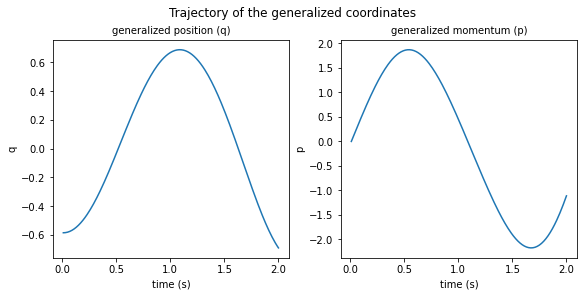

In [ ]:
plot_traj_pend(t_eval_tt[0], x_tt[0,:,0], x_tt[0,:,1], coord_type = 'hamiltonian')

In [ ]:
q, p, t_eval, energy, derivatives = multiple_trajectories(time_steps=time_steps, num_trajectories=2, device=device, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')

In [ ]:
shapes = [print(i.shape) for i in [q, p, t_eval, energy, derivatives]]

torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200, 2])
torch.Size([200, 2, 2])


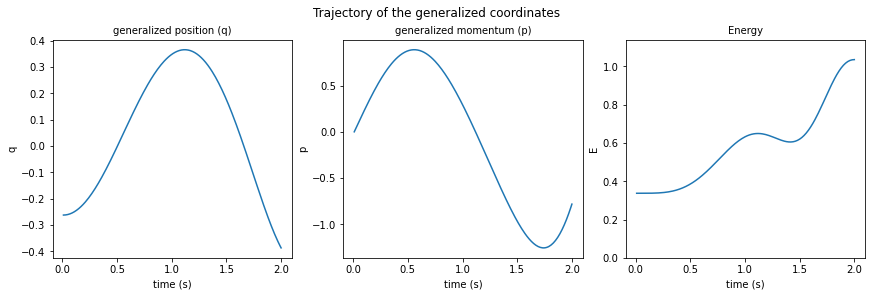

In [ ]:
plot_traj_pend(t_eval, q[:,0], p[:,0], energy[:,0], coord_type = 'hamiltonian') # sanity check 

In [ ]:
model = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation='tanh')

In [ ]:
count_parameters(model)

8551

In [ ]:
H_net = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='tanh')

In [ ]:

model = U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=None,
                    assume_canonical_coords=True, baseline=True, structure=False)

In [ ]:
s_h = model(t_eval_tt, x_tt) # sanity check
print(s_h.shape)

torch.Size([3, 200, 2])


In [ ]:
G_net = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=2, output_dim=2, activation='tanh')
H_net = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation='tanh')

In [ ]:
G_net = g_func

In [ ]:
model = Nes_HDNN(u_func = u_func, G_net=G_net, H_net=H_net, device=device)

In [ ]:
model(t_eval_tt[:,1],x_tt[:,1,:])

tensor([[-0.0239,  0.0052],
        [-0.0509,  0.0324],
        [-0.0168,  0.0027]], grad_fn=<CatBackward0>)

In [ ]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=1, dec_in_dim = 1, dec_out_dim = 2, activation='tanh')

In [ ]:
count_parameters(autoencoder)

8835

In [ ]:
x_tt.shape

torch.Size([3, 40, 2])

In [ ]:
test = x_tt[:,:5,:]

In [ ]:
test.shape

torch.Size([3, 5, 2])

In [ ]:
test[:,0,:].shape

torch.Size([3, 2])

In [ ]:
z,x = autoencoder(test[:,0,:])

In [ ]:
z

tensor([[-0.0269],
        [-0.0547],
        [-0.0416]], grad_fn=<AddmmBackward0>)

In [ ]:
x

tensor([[0.0984, 0.0463],
        [0.1011, 0.0512],
        [0.0999, 0.0489]], grad_fn=<AddmmBackward0>)

# Training

## other

In [59]:
device = set_device()
y0 = None
noise_std = 0.0
Ts = 0.05
C = 0.0
m = 1
g = 9.81
l = 1
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 2.0
u_func.params['f0'] = 0
u_func.params['f1'] = 1
u_func.params['scale'] = 1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
time_steps = 40
num_trajectories = 125
batch_size = 100
proportion = 0.8

train_loader, test_loader = load_data_device(time_steps=time_steps, num_trajectories=num_trajectories, 
device=device, batch_size = batch_size, proportion = proportion, shuffle=False, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')

cpu


In [60]:
H_net = MLP(input_dim=2, hidden_dim=60, nb_hidden_layers=2, output_dim=1, activation='x+sin(x)^2')

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device)
model.to(device)

count_parameters(model)

w = torch.tensor([1.0,1.0], device = device)
horizon_list = [20,25,30,35,40]
switch_steps = [100,100,100,100,100]
epoch_num = sum(switch_steps)
print(epoch_num)

500


In [65]:
stats = train(model, Ts, train_loader, test_loader, w, horizon=False, horizon_type='auto',
          horizon_list = horizon_list, 
          switch_steps = switch_steps,
          epochs = epoch_num, 
          loss_type = 'L2weighted')

horizon length : 20
epoch    0 | train time 0.33 | train loss 5.937325e+00 | test loss 6.783599e+00 | test time 0.13  
horizon length : 20
epoch    1 | train time 0.25 | train loss 5.714859e+00 
epoch    2 | train time 0.25 | train loss 5.499561e+00 
epoch    3 | train time 0.24 | train loss 5.291371e+00 
epoch    4 | train time 0.27 | train loss 5.090811e+00 
epoch    5 | train time 0.25 | train loss 4.898531e+00 
epoch    6 | train time 0.25 | train loss 4.714892e+00 
epoch    7 | train time 0.26 | train loss 4.539643e+00 
epoch    8 | train time 0.25 | train loss 4.371732e+00 
epoch    9 | train time 0.23 | train loss 4.209417e+00 
epoch   10 | train time 0.24 | train loss 4.050585e+00 | test loss 4.378191e+00 | test time 0.10  
epoch   11 | train time 0.24 | train loss 3.893082e+00 
epoch   12 | train time 0.22 | train loss 3.735056e+00 
epoch   13 | train time 0.24 | train loss 3.575216e+00 
epoch   14 | train time 0.32 | train loss 3.412929e+00 
epoch   15 | train time 0.27 | tra

## with resnets

### config 1

In [147]:
device = set_device()
y0 = None
noise_std = 0.0
Ts = 0.05
C = 0.0
m = 1
g = 9.81
l = 1
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 2.0
u_func.params['f0'] = 0
u_func.params['f1'] = 1
u_func.params['scale'] = 1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
time_steps = 40
num_trajectories = 125
batch_size = 100
proportion = 0.8

train_loader, test_loader = load_data_device(time_steps=time_steps, num_trajectories=num_trajectories, 
device=device, batch_size = batch_size, proportion = proportion, shuffle=False, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')


model_name = 'NESHDNN_resnet_conf1'

H_net = ResNet_config1(resblock_list=[0], num_blocks = 6, input_dim=2, hidden_dim=25, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
save_prefix = model_name +'_'+ utype +'_'+  'traj'+str(num_trajectories)+'_'
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)
model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
w = torch.tensor([1.0,1.0], device = device)
horizon_list = [20,25,30,35,40]
switch_steps = [200,200,200,200,200]
epoch_num = sum(switch_steps)
print(epoch_num)

stats = train(model, Ts, train_loader, test_loader, w, resnet_config=1, horizon=False, horizon_type='auto',
          horizon_list = horizon_list, 
          switch_steps = switch_steps,
          epochs = epoch_num, 
          loss_type = 'L2weighted')

cpu
mlp number of parameters : 1402
resblock number of parameters : 1376
Total number of H_net parameters : 9658
1000
horizon length : 20
epoch    0 | train time 0.25 | train loss 7.502776e+00 | test loss 5.713138e+00 | test time 0.09  
epoch    1 | train time 0.24 | train loss 7.415285e+00 
epoch    2 | train time 0.23 | train loss 7.328288e+00 
epoch    3 | train time 0.22 | train loss 7.241876e+00 
epoch    4 | train time 0.23 | train loss 7.156121e+00 
epoch    5 | train time 0.23 | train loss 7.071078e+00 
epoch    6 | train time 0.23 | train loss 6.986759e+00 
epoch    7 | train time 0.23 | train loss 6.903136e+00 
epoch    8 | train time 0.24 | train loss 6.820168e+00 
epoch    9 | train time 0.28 | train loss 6.737800e+00 
epoch   10 | train time 0.30 | train loss 6.655959e+00 | test loss 5.050061e+00 | test time 0.11  
epoch   11 | train time 0.24 | train loss 6.574549e+00 
epoch   12 | train time 0.23 | train loss 6.493455e+00 
epoch   13 | train time 0.30 | train loss 6.4125

### config 2

In [159]:
device = set_device()
y0 = None
noise_std = 0.0
Ts = 0.05
C = 0.0
m = 1
g = 9.81
l = 1
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 2.0
u_func.params['f0'] = 0
u_func.params['f1'] = 1
u_func.params['scale'] = 1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
time_steps = 40
num_trajectories = 125
batch_size = 100
proportion = 0.8

train_loader, test_loader = load_data_device(time_steps=time_steps, num_trajectories=num_trajectories, 
device=device, batch_size = batch_size, proportion = proportion, shuffle=False, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')



cpu


In [161]:
model_name = 'NESHDNN_resnet_conf2_wholetrajectory'

H_net = ResNet_config2(resblock_list=[0], num_blocks = 12, input_dim=2, hidden_dim=25, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
save_prefix = model_name +'_'+ utype +'_'+  'traj'+str(num_trajectories)+'_'
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)
model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
w = torch.tensor([1.0,1.0], device = device)
horizon_list = [40,40,40,40,40]
switch_steps = [100,100,100,100,100]
epoch_num = sum(switch_steps)
print(epoch_num)
resnet_config=3

mlp number of parameters : 1402
resblock number of parameters : 1427
Total number of H_net parameters : 18526
500


In [162]:
stats = train(model, Ts, train_loader, test_loader, w, resnet_config=2, horizon=False, horizon_type='auto',
          horizon_list = horizon_list, 
          switch_steps = switch_steps,
          epochs = epoch_num, 
          loss_type = 'L2weighted')

horizon length : 40
epoch    0 | train time 0.84 | train loss 6.996072e+00 | test loss 1.086043e+01 | test time 0.31  
epoch    1 | train time 0.83 | train loss 6.922450e+00 
epoch    2 | train time 0.73 | train loss 6.853330e+00 
epoch    3 | train time 0.76 | train loss 6.788297e+00 
epoch    4 | train time 0.79 | train loss 6.726825e+00 
epoch    5 | train time 0.81 | train loss 6.668346e+00 
epoch    6 | train time 0.82 | train loss 6.612318e+00 
epoch    7 | train time 0.72 | train loss 6.558257e+00 
epoch    8 | train time 0.77 | train loss 6.505733e+00 
epoch    9 | train time 0.73 | train loss 6.454364e+00 
epoch   10 | train time 0.80 | train loss 6.403818e+00 | test loss 9.978134e+00 | test time 0.31  
epoch   11 | train time 0.86 | train loss 6.353807e+00 
epoch   12 | train time 0.76 | train loss 6.304102e+00 
epoch   13 | train time 0.83 | train loss 6.254518e+00 
epoch   14 | train time 0.78 | train loss 6.204907e+00 
epoch   15 | train time 0.83 | train loss 6.155163e+00

### config 3

In [86]:
device = set_device()
y0 = None
noise_std = 0.0
Ts = 0.05
C = 0.0
m = 1
g = 9.81
l = 1
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 2.0
u_func.params['f0'] = 0
u_func.params['f1'] = 1
u_func.params['scale'] = 1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
time_steps = 40
num_trajectories = 125
batch_size = 100
proportion = 0.8

train_loader, test_loader = load_data_device(time_steps=time_steps, num_trajectories=num_trajectories, 
device=device, batch_size = batch_size, proportion = proportion, shuffle=False, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func, g_func=g_func, coord_type = 'hamiltonian')



cpu


In [99]:
model_name = 'NESHDNN_resnet_conf3'
save_prefix = model_name +'_'+ utype +'_'+  'traj'+str(num_trajectories)+'_'
H_net = ResNet_config3(resblock_list=[0], num_blocks = 6, input_dim=2, hidden_dim=25, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
save_prefix = model_name +'_'+ utype +'_'+  'traj'+str(num_trajectories)+'_'
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)
model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
w = torch.tensor([1.0,1.0], device = device)
horizon_list = [20,25,30,35,40]
switch_steps = [200,200,200,200,200]
epoch_num = sum(switch_steps)
print(epoch_num)
resnet_config=3

mlp number of parameters : 1402
resblock number of parameters : 1427
Total number of H_net parameters : 9964
1000


In [100]:
stats = train(model, Ts, train_loader, test_loader, w, resnet_config=3, horizon=False, horizon_type='auto',
          horizon_list = horizon_list, 
          switch_steps = switch_steps,
          epochs = epoch_num, 
          loss_type = 'L2weighted')

horizon length : 20
epoch    0 | train time 0.27 | train loss 7.792051e+00 | test loss 7.718890e+00 | test time 0.12  
epoch    1 | train time 0.23 | train loss 7.734725e+00 
epoch    2 | train time 0.24 | train loss 7.679690e+00 
epoch    3 | train time 0.26 | train loss 7.626630e+00 
epoch    4 | train time 0.26 | train loss 7.575156e+00 
epoch    5 | train time 0.25 | train loss 7.524799e+00 
epoch    6 | train time 0.24 | train loss 7.475108e+00 
epoch    7 | train time 0.24 | train loss 7.425702e+00 
epoch    8 | train time 0.24 | train loss 7.376236e+00 
epoch    9 | train time 0.24 | train loss 7.326383e+00 
epoch   10 | train time 0.24 | train loss 7.275822e+00 | test loss 7.243504e+00 | test time 0.12  
epoch   11 | train time 0.23 | train loss 7.224242e+00 
epoch   12 | train time 0.29 | train loss 7.171357e+00 
epoch   13 | train time 0.36 | train loss 7.116893e+00 
epoch   14 | train time 0.29 | train loss 7.060596e+00 
epoch   15 | train time 0.26 | train loss 7.002233e+00

# Result plots

## plot functions

In [47]:
def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None,
                            horizons = [100,150,200,250,300],
                            horizon_steps = [200,400,550,700,850],
                            title='train and test loss per epoch' ):
    ''' 
    Description:

    Inputs:

    Outpus:

    '''
    fig, ax = plt.subplots(figsize=(10,4))
    # ,constrained_layout=True)
    # fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')

    if not loss_test == []: # if loss_test exists
        plt.plot(epochs[::10], loss_test, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

    if horizons:
        for i, epoch_num in enumerate(horizon_steps[:-1]):
            ax.annotate(
            'horizon = %d'%horizons[i],
            xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
            xytext=(-70, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc,angleA=0,armA=50,rad=10"
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"
                            ))
        ax.annotate(
        'horizon = %d'%horizons[-1],
        xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
        xytext=(+20, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

In [48]:
def plot_results(model, train_loader, train_horizon, n, u_func, g_func, C, m, g, l, file_path, show_pred = True, title = 'Trajectory of the generalized coordinates', coord_type = 'hamiltonian'):
    x, t_eval = next(iter(train_loader)) 
    t_eval = t_eval[0,:]
    test_x_hat = odeint(model, x[n:n+1, 0, :], t_eval, method='rk4') 

    energy_nom, _ = get_energy_pendulum(t_eval, u_func, g_func, x[n, :, 0], x[n, :, 1], C, m, g, l)
    energy_pred, _ = get_energy_pendulum(t_eval, u_func, g_func, test_x_hat[:, 0, 0], test_x_hat[:, 0, 1], C, m, g, l)
    input = u_func.forward(t_eval).cpu().detach()
    t_eval = t_eval.cpu().detach()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12, 4),constrained_layout=True)#, sharex=True)# , sharey=True)

    fig.suptitle(title, fontsize=12)

    for q, p, energy, label,color in [(x[n,:,0],x[n,:,1], energy_nom, 'nominal','C0'),(test_x_hat[:, 0, 0], test_x_hat[:, 0, 1], energy_pred, 'train','g')]:
        q = q.cpu().detach()
        p = p.cpu().detach()
        energy = energy.cpu().detach()
        
        ax1.plot(t_eval, q, label=label, color=color)
        ax3.plot(t_eval, energy, label=label, color=color)
        ax2.plot(t_eval, p, label=label, color=color)

        if show_pred==True and label=='train' :
            ax1.plot(t_eval[(train_horizon-1):], q[(train_horizon-1):], label='predicted', color='r')
            ax2.plot(t_eval[train_horizon-1:], p[train_horizon-1:], label='predicted', color='r')
            ax3.plot(t_eval[train_horizon-1:], energy[train_horizon-1:], label='predicted', color='r')
        
        
        ax1.legend()
        ax1.set_title('generalized position (q)', fontsize=10)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('q')

        # ax2.legend()
        ax2.set_title('generalized momentum (p)', fontsize=10)
        ax2.set_xlabel('time (s)')
        ax2.set_ylabel('p')


        # ax3.legend()
        ax3.set_title('Energy', fontsize=10)
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('E')
        ax3.set_ylim((0,torch.max(energy)*1.1))

    ax4.plot(t_eval, input, label='input')
    ax4.set_title('Input', fontsize=10)
    ax4.set_xlabel('time (s)')
    ax4.set_ylabel('U')
    # ax4.legend()
    # ax4.set_ylim((0,torch.max(input)*1.1))

    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q}[rad/s]$')
        
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return


## Plots

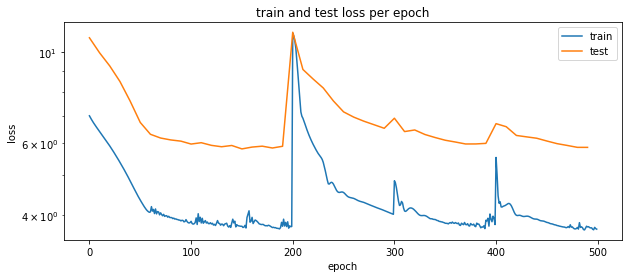

In [163]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path='../data/img/'+save_prefix+'simple_pend.png',
                            horizons = None,
                            horizon_steps = [200,400,550,700,850],
                            title='train and test loss per epoch' )

In [149]:
model.u_func = U_FUNC(utype='chirp')
model.u_func.params['T'] = 2.0
model.u_func.params['f0'] = 0
model.u_func.params['f1'] = 1
model.u_func.params['scale'] = 1

In [150]:
train_horizon=40

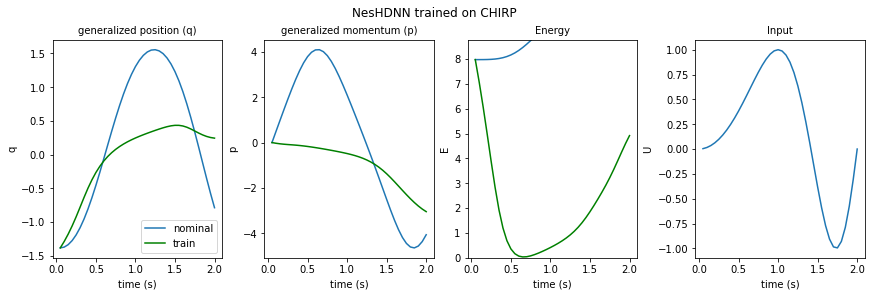

In [164]:
plot_results(model, train_loader, train_horizon, 10, u_func, 
        g_func, C, m, g, l, file_path='../data/img/'+save_prefix+'simple_pend.png', show_pred = False, 
        title ='NesHDNN trained on CHIRP ',coord_type = 'hamiltonian')

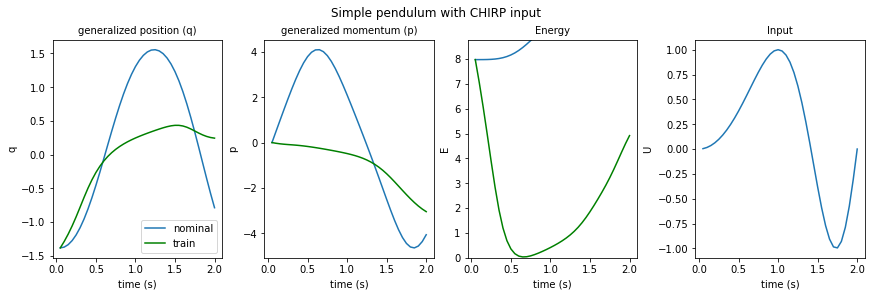

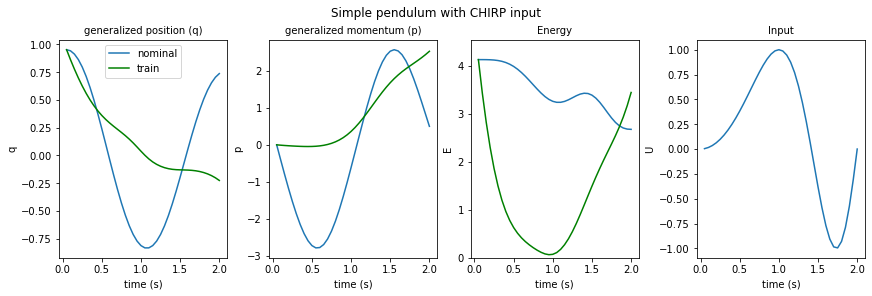

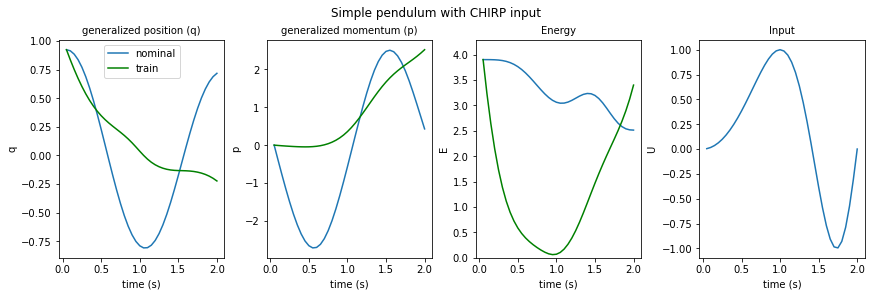

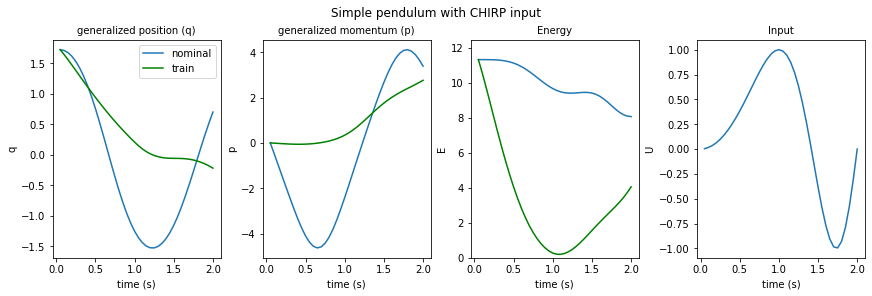

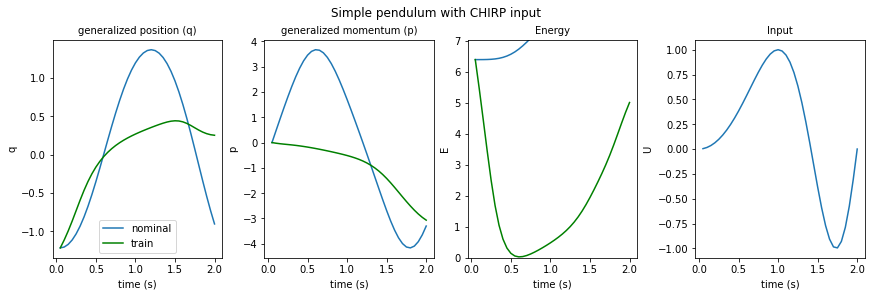

In [165]:
for n in range(10,15):
    plot_results(model, train_loader, train_horizon, n, u_func, g_func, C, m, g, l, file_path=None, show_pred = False, title ='Simple pendulum with CHIRP input',coord_type = 'hamiltonian')

In [166]:
u_func_none = U_FUNC(utype=None)

In [167]:
train_loader_no_input, test_loader_no_input = load_data_device(time_steps=200, num_trajectories=125, device=device, batch_size=100, proportion=0.8, shuffle=False, Ts=Ts, y0=y0, 
                                noise_std=noise_std, C=C, m=m, g=g, l=l, u_func=u_func_none, g_func=g_func, coord_type = 'hamiltonian')

In [168]:
model.u_func = U_FUNC(utype=None)

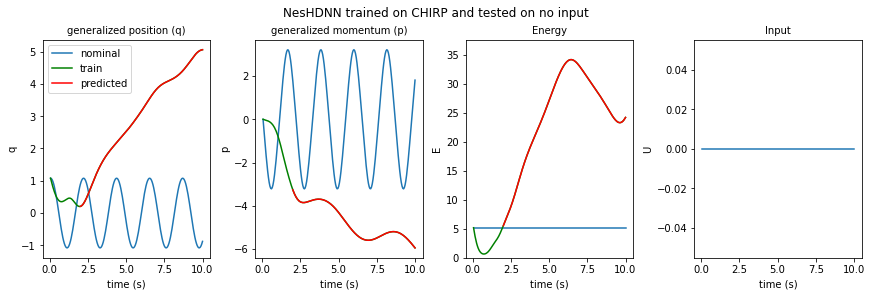

In [169]:
plot_results(model, train_loader_no_input, train_horizon, 10, u_func_none, 
        g_func, C, m, g, l, file_path='../data/img/'+save_prefix+'noinput_simple_pend.png', show_pred = True, 
        title ='NesHDNN trained on CHIRP and tested on no input',coord_type = 'hamiltonian')

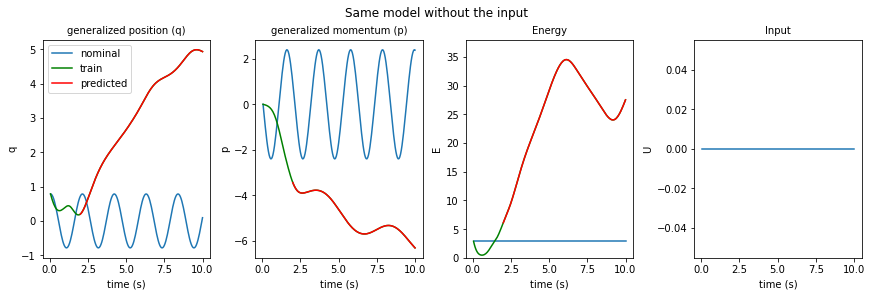

In [170]:
plot_results(model, train_loader_no_input, train_horizon, 14, u_func_none, 
        g_func, C, m, g, l, file_path='../data/img/'+save_prefix+'simple_pend_noinput_2.png', show_pred = True, 
        title ='Same model without the input',coord_type = 'hamiltonian')

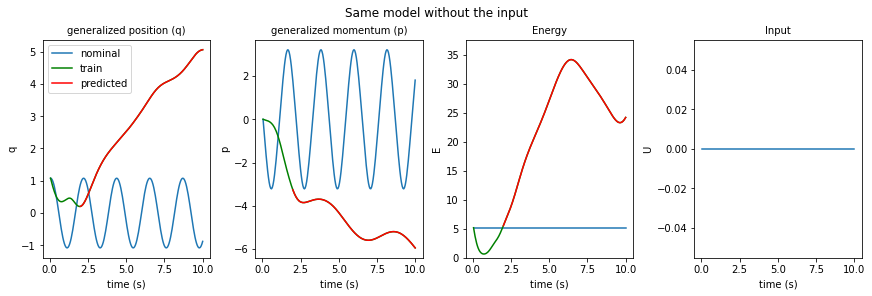

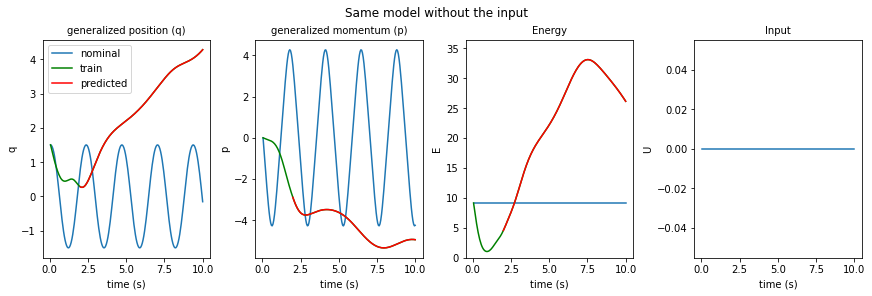

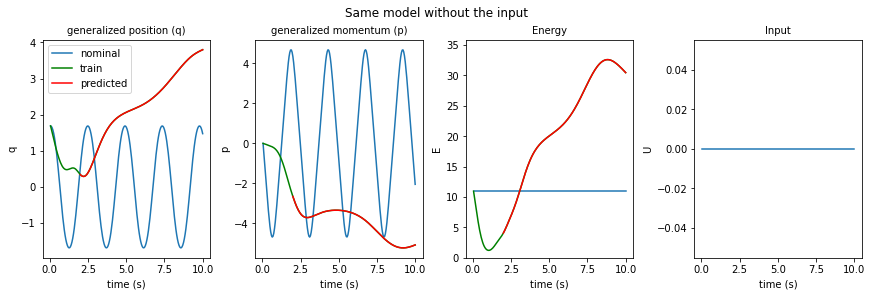

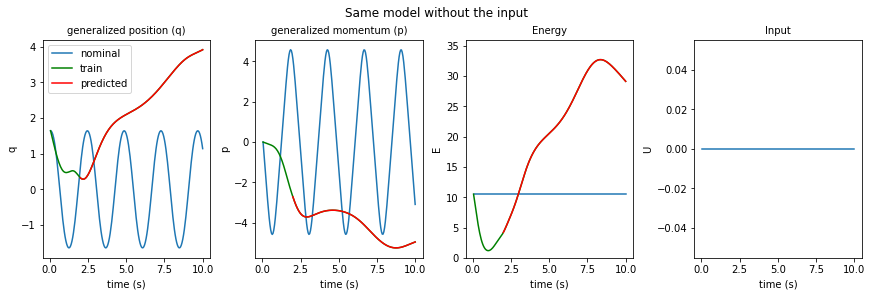

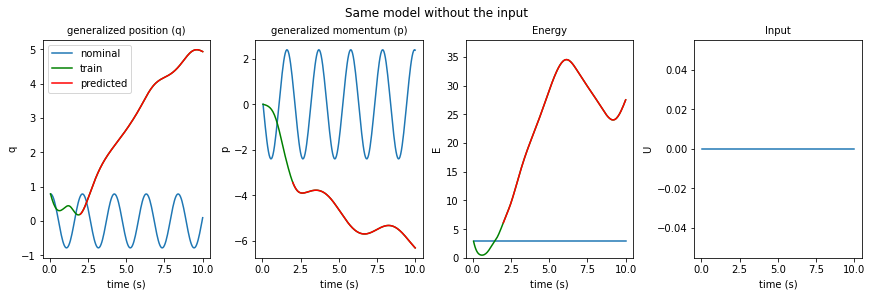

In [171]:
for n in range(10,15):
    plot_results(model, train_loader_no_input, train_horizon, n, u_func_none, g_func, C, m, g, l, file_path=None, show_pred = True, title ='Same model without the input', coord_type = 'hamiltonian')

In [213]:
model.G_net

MLP(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (hidden_layers): Sequential(
    (0): hidden_Layer(
      (fc): Linear(in_features=40, out_features=40, bias=True)
    )
  )
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)

In [293]:
x,t = next(iter(train_loader))

In [223]:
x.shape

torch.Size([100, 40, 2])

In [224]:
x[0,0,:]

tensor([0.5692, 0.0000])

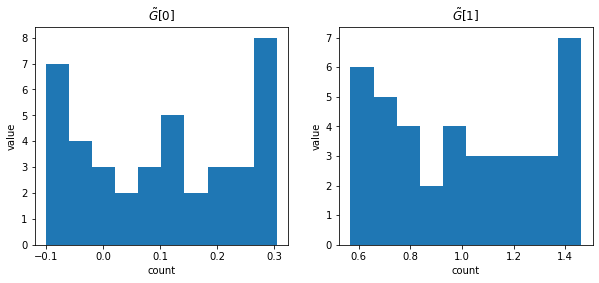

In [280]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
  
# plt.suptitle('test')
ax[0].hist(model.G_net(x[0,:,:]).detach().numpy()[:,0])
ax[0].set_title(r'${\tilde{G} [0]}$')
ax[0].set_xlabel('count')
ax[0].set_ylabel('value')
ax[1].hist(model.G_net(x[0,:,:]).detach().numpy()[:,1])
ax[1].set_title(r'${\tilde{G} [1]}$')
ax[1].set_xlabel('count')
ax[1].set_ylabel('value')

plt.savefig('../data/img/G_distribution.png', format="png",dpi=400)

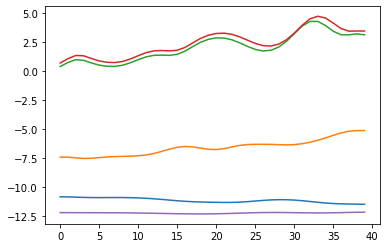

In [294]:
for n in range(5):
    plt.plot(model.H_net(x[n,:,:]).detach().numpy())